In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sequence-cluster/sequence_clusters_with_reps.csv
/kaggle/input/7enzymes/enzymes_plastics_selected7.csv
/kaggle/input/blast-results/blast_results/cluster68_rep_hits.fasta
/kaggle/input/blast-results/blast_results/cluster103_rep_hits.fasta
/kaggle/input/blast-results/blast_results/cluster39_rep_hits.fasta
/kaggle/input/blast-results/blast_results/cluster83_rep_hits.fasta
/kaggle/input/blast-results/blast_results/cluster63_rep_hits.fasta
/kaggle/input/blast-results/blast_results/cluster62_rep_hits.fasta
/kaggle/input/blast-results/blast_results/cluster111_rep_hits.fasta
/kaggle/input/blast-results/blast_results/cluster108_rep_hits.fasta
/kaggle/input/blast-results/blast_results/cluster127_rep_hits.fasta
/kaggle/input/blast-results/blast_results/cluster38_rep_hits.fasta
/kaggle/input/blast-results/blast_results/cluster34_rep_hits.fasta
/kaggle/input/blast-results/blast_results/cluster156_rep_hits.fasta
/kaggle/input/blast-results/blast_results/cluster44_rep_hits.fasta
/kaggle

In [2]:
import os
import pandas as pd

csv_file = "/kaggle/input/sequence-cluster/sequence_clusters_with_reps.csv"
fasta_input_dir = "/kaggle/input/blast-results/blast_results"

fasta_output_dir = "/kaggle/working/fasta_output"
os.makedirs(fasta_output_dir, exist_ok=True)

df = pd.read_csv(csv_file)

for file in os.listdir(fasta_input_dir):
    if file.endswith("_rep_hits.fasta"):
        src_path = os.path.join(fasta_input_dir, file)
        dst_path = os.path.join(fasta_output_dir, file)
        with open(src_path, "r") as src, open(dst_path, "w") as dst:
            dst.write(src.read())

for _, row in df.iterrows():
    cluster_id = row["cluster_id"]
    seq_id = row["sequence_id"]
    sequence = row["sequence"]

    fasta_file = os.path.join(fasta_output_dir, f"cluster{cluster_id}_rep_hits.fasta")

    with open(fasta_file, "a") as f:
        f.write(f">{seq_id}\n")
        f.write(f"{sequence}\n")



In [ ]:
import os
import torch
import numpy as np
from Bio import AlignIO
from torch_geometric.data import Data
import random
import time
from tqdm import tqdm

fasta_dir = "/kaggle/input/msa-output/msa_output1"
graph_dir = "/kaggle/working/graphs1"
os.makedirs(graph_dir, exist_ok=True)

def shannon_entropy(column):
    freqs = [column.count(aa)/len(column) for aa in set(column) if aa != "-"]
    return -sum(p*np.log2(p) for p in freqs if p > 0)

def mutual_information(col_i, col_j):
    aa_set = list(set(col_i + col_j) - {"-"})
    if not aa_set:
        return 0.0
    mi = 0.0
    for a in aa_set:
        for b in aa_set:
            p_ab = sum((x==a and y==b) for x,y in zip(col_i,col_j)) / len(col_i)
            p_a = col_i.count(a)/len(col_i)
            p_b = col_j.count(b)/len(col_j)
            if p_ab > 0:
                mi += p_ab * np.log2(p_ab/(p_a*p_b))
    return mi

files = [f for f in os.listdir(fasta_dir) if f.endswith(".fasta")]
total_files = len(files)

print(f"Found {total_files} clusters to process\n")

start_all = time.time()

for idx, file in enumerate(files, 1):
    cluster_name = file.replace(".fasta", "")
    msa_fasta = os.path.join(fasta_dir, file)

    print(f"\n[{idx}/{total_files}] Processing {cluster_name}...")
    start_time = time.time()

    alignment = AlignIO.read(msa_fasta, "fasta")
    L = alignment.get_alignment_length()
    N = len(alignment)

    node_features = []
    for i in range(L):
        col = [rec.seq[i] for rec in alignment]
        entropy = shannon_entropy(col)
        aa_counts = [col.count(aa)/N for aa in "ACDEFGHIKLMNPQRSTVWY"]
        node_features.append([entropy] + aa_counts)
    node_features = torch.tensor(node_features, dtype=torch.float)

    edge_index, edge_attr = [], []

    for i in range(L-1):
        edge_index.append([i, i+1])
        edge_index.append([i+1, i])
        edge_attr.append([1.0])
        edge_attr.append([1.0])

    for i in tqdm(range(L), desc=f"   MI edges for {cluster_name}", leave=False):
        for j in range(i+1, L):
            mi = mutual_information(
                [rec.seq[i] for rec in alignment],
                [rec.seq[j] for rec in alignment]
            )
            if mi > 0.1:
                edge_index.append([i, j])
                edge_index.append([j, i])
                edge_attr.append([mi])
                edge_attr.append([mi])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)

    graph = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)
    torch.save(graph, os.path.join(graph_dir, f"{cluster_name}.pt"))

    elapsed = time.time() - start_time
    avg_time = (time.time() - start_all) / idx
    eta = avg_time * (total_files - idx)
    print(f"Done {cluster_name} | Time: {elapsed:.2f}s | ETA: {eta/60:.1f} min left")

total_time = time.time() - start_all
print(f"\n All clusters processed in {total_time/60:.2f} minutes")

sample_file = os.path.join(graph_dir, random.choice(os.listdir(graph_dir)))
print(f"\n Checking: {sample_file}")
g = torch.load(sample_file)
print("x:", g.x.shape)
print("edge_index:", g.edge_index.shape)
print("edge_attr:", g.edge_attr.shape)
print(g)


📂 Found 184 clusters to process


🔹 [1/184] Processing cluster82_rep_hits_aligned...


✅ Done cluster82_rep_hits_aligned | Time: 1357.81s | ETA: 4141.3 min left

🔹 [2/184] Processing cluster166_rep_hits_aligned...


✅ Done cluster166_rep_hits_aligned | Time: 422.60s | ETA: 2700.3 min left

🔹 [3/184] Processing cluster45_rep_hits_aligned...


   MI edges for cluster45_rep_hits_aligned:  40%|███▉      | 1085/2734 [37:04<1:01:24,  2.23s/it]

Data(x=[277, 21], edge_index=[2, 11616], edge_attr=[11616, 1])


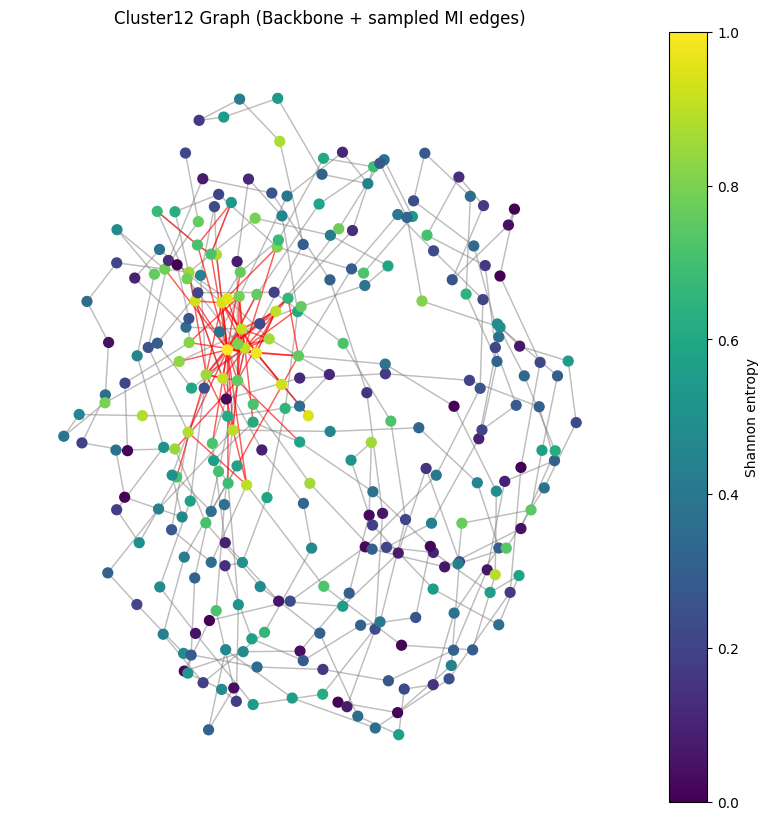

In [7]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
import random
import torch_geometric
graph_path = "/kaggle/input/graphs/graphs1/cluster125_rep_hits_aligned.pt"
g = torch.load(graph_path, weights_only=False)

print(g)

G = nx.Graph()
num_nodes = g.x.shape[0]

entropies = g.x[:, 0].numpy()

for i in range(num_nodes):
    G.add_node(i, entropy=entropies[i])

edge_index = g.edge_index.t().numpy()
edge_attr = g.edge_attr.numpy()

backbone_edges = [(u, v) for (u, v), w in zip(edge_index, edge_attr) if w == 1.0]
mi_edges = [(u, v) for (u, v), w in zip(edge_index, edge_attr) if w > 1.0]

sampled_mi_edges = random.sample(mi_edges,len(mi_edges))

G.add_edges_from(backbone_edges, kind="backbone")
G.add_edges_from(sampled_mi_edges, kind="mi")


pos = nx.spring_layout(G, seed=42, k=0.2)


plt.figure(figsize=(10, 10))

nx.draw_networkx_nodes(
    G, pos,
    node_size=50,
    node_color=[G.nodes[i]["entropy"] for i in G.nodes()],
    cmap=plt.cm.viridis
)

nx.draw_networkx_edges(G, pos, edgelist=backbone_edges, edge_color="gray", alpha=0.3)
nx.draw_networkx_edges(G, pos, edgelist=sampled_mi_edges, edge_color="red", alpha=0.4)

plt.title("Cluster12 Graph (Backbone + sampled MI edges)")
plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.viridis),
             ax=plt.gca(), label="Shannon entropy")
plt.axis("off")
plt.show()


In [5]:
import pandas as pd

csv_clusters = "/kaggle/input/sequence-cluster/sequence_clusters_with_reps.csv"
csv_labels = "/kaggle/input/7enzymes/enzymes_plastics_selected7.csv"

df_clusters = pd.read_csv(csv_clusters)
df_labels = pd.read_csv(csv_labels)

def clean_seq(s):
    return str(s).replace("-", "").replace("\n", "").upper()

df_clusters["sequence_clean"] = df_clusters["sequence"].apply(clean_seq)
df_labels["sequence_clean"] = df_labels["sequence"].apply(clean_seq)

df_merged = df_clusters.merge(df_labels, on="sequence_clean", how="inner")

label_cols = ["PET", "PHB", "PHA", "PLA", "PCL", "PU/PUR", "NYLON/PA"]

def majority_label(subdf):
    sums = subdf[label_cols].sum()
    if sums.sum() == 0:
        return "Unknown"
    return sums.idxmax()

cluster_to_label = df_merged.groupby("cluster_id").apply(majority_label).to_dict()

df_cluster_labels = pd.DataFrame(list(cluster_to_label.items()), columns=["cluster_id", "enzyme_label"])
df_cluster_labels.head()


/tmp/ipykernel_36/2641484033.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cluster_to_label = df_merged.groupby("cluster_id").apply(majority_label).to_dict()


,cluster_id,enzyme_label
0,0,PET
1,1,PCL
2,2,PET
3,3,PCL
4,4,PET


In [6]:
df_cluster_labels["file"] = df_cluster_labels["cluster_id"].apply(
    lambda cid: f"cluster{cid}_rep_hits_aligned.pt"
)
df_cluster_labels.to_csv("/kaggle/working/index.csv")
print(df_cluster_labels)

     cluster_id enzyme_label                            file
0             0          PET    cluster0_rep_hits_aligned.pt
1             1          PCL    cluster1_rep_hits_aligned.pt
2             2          PET    cluster2_rep_hits_aligned.pt
3             3          PCL    cluster3_rep_hits_aligned.pt
4             4          PET    cluster4_rep_hits_aligned.pt
..          ...          ...                             ...
179         179          PET  cluster179_rep_hits_aligned.pt
180         180          PHB  cluster180_rep_hits_aligned.pt
181         181          PHB  cluster181_rep_hits_aligned.pt
182         182          PHB  cluster182_rep_hits_aligned.pt
183         183          PHB  cluster183_rep_hits_aligned.pt

[184 rows x 3 columns]


In [21]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch_geometric.data import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import AutoTokenizer, AutoModel

graph_dir = "/kaggle/input/graphs/graphs1"
label_csv = "/kaggle/working/index.csv"
cluster_csv = "/kaggle/input/sequence-cluster/sequence_clusters_with_reps.csv"

df_labels = pd.read_csv(label_csv)
le = LabelEncoder()
df_labels["label_id"] = le.fit_transform(df_labels["enzyme_label"])


esm_model_name = "facebook/esm2_t33_650M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(esm_model_name)
esm_model = AutoModel.from_pretrained(esm_model_name).cuda()

df_clusters = pd.read_csv(cluster_csv)
rep_sequences = df_clusters[df_clusters["is_representative"] == 1][["cluster_id", "sequence"]]

cluster2esm = {}
def get_esm_embedding(seq):
    inputs = tokenizer(seq, return_tensors="pt", truncation=True, max_length=1024)
    inputs = {k: v.cuda() for k, v in inputs.items()}
    with torch.no_grad():
        outputs = esm_model(**inputs)
        hidden = outputs.last_hidden_state.squeeze(0)  # [L, 1280]
        emb = hidden.mean(dim=0)  
    return emb.cpu()

for _, row in rep_sequences.iterrows():
    cid = row["cluster_id"]
    seq = row["sequence"].replace("-", "").upper()
    cluster2esm[cid] = get_esm_embedding(seq)


graphs, labels, esm_embeddings = [], [], []

for _, row in df_labels.iterrows():
    file_path = os.path.join(graph_dir, row["file"])
    cluster_id = row["cluster_id"]
    if os.path.exists(file_path) and cluster_id in cluster2esm:
        g = torch.load(file_path, weights_only=False)
        g.y = torch.tensor([row["label_id"]], dtype=torch.long)
        graphs.append(g)
        labels.append(row["label_id"])
        esm_embeddings.append(cluster2esm[cluster_id])  

esm_embeddings = torch.stack(esm_embeddings)


train_idx, test_idx = train_test_split(
    range(len(graphs)), test_size=0.3, stratify=labels, random_state=42
)
train_dataset = [(graphs[i], esm_embeddings[i], labels[i]) for i in train_idx]
test_dataset = [(graphs[i], esm_embeddings[i], labels[i]) for i in test_idx]

class GraphSeqDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, idx):
        g, esm, label = self.dataset[idx]
        return g, esm, label

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)
class GNNOnly(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, num_classes)
    def forward(self, g):
        x, edge_index, batch = g.x, g.edge_index, g.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        gnn_out = global_mean_pool(x, batch)
        return self.lin(gnn_out)

class ESMOnly(nn.Module):
    def __init__(self, esm_dim, num_classes):
        super().__init__()
        self.lin1 = nn.Linear(esm_dim, 512)
        self.lin2 = nn.Linear(512, num_classes)
    def forward(self, esm_emb):
        x = F.relu(self.lin1(esm_emb))
        return self.lin2(x)

class GNN_ESM(nn.Module):
    def __init__(self, in_channels, hidden_channels, esm_dim, num_classes):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels + esm_dim, num_classes)
    def forward(self, g, esm_emb):
        x, edge_index, batch = g.x, g.edge_index, g.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        gnn_out = global_mean_pool(x, batch)
        fusion = torch.cat([gnn_out, esm_emb], dim=1)
        return self.lin(fusion)

def train_model(model, optimizer, criterion, mode="fusion"):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for g, esm, label in train_loader:
        g, esm, label = g.to(device), esm.to(device), torch.tensor(label).to(device)
        optimizer.zero_grad()
        if mode == "gnn":
            out = model(g)
        elif mode == "esm":
            out = model(esm)
        else:
            out = model(g, esm)
        loss = criterion(out, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = out.argmax(dim=1)
        correct += (pred == label).sum().item()
        total += label.size(0)
    return total_loss / len(train_loader), correct / total

def eval_model(model, mode="fusion"):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for g, esm, label in test_loader:
            g, esm, label = g.to(device), esm.to(device), torch.tensor(label).to(device)
            if mode == "gnn":
                out = model(g)
            elif mode == "esm":
                out = model(esm)
            else:
                out = model(g, esm)
            pred = out.argmax(dim=1).cpu().numpy()
            preds.extend(pred)
            trues.extend(label.cpu().numpy())
    acc = (torch.tensor(preds) == torch.tensor(trues)).float().mean().item()
    return acc, preds, trues

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

configs = {
    "GNN-only": (GNNOnly(graphs[0].x.shape[1], 128, len(le.classes_)), "gnn"),
    "ESM-only": (ESMOnly(esm_embeddings.shape[1], len(le.classes_)), "esm"),
    "Fusion": (GNN_ESM(graphs[0].x.shape[1], 128, esm_embeddings.shape[1], len(le.classes_)), "fusion")
}

for name, (model, mode) in configs.items():
    print(f"\n=== {name} ===")
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    for epoch in range(1, 51):
        loss, train_acc = train_model(model, optimizer, criterion, mode)
        test_acc, preds, trues = eval_model(model, mode)
        if epoch % 10 == 0:
            print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

    print("\n--- Classification Report ---")
    print(classification_report(trues, preds, target_names=le.classes_))


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ ESM2 embedding 提取完成: 184 clusters
✅ 共载入 184 个图

=== GNN-only ===


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/tmp/ipykernel_36/3205937917.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  g, esm, label = g.to(device), esm.to(device), torch.tensor(label).to(device)
/tmp/ipykernel_36/3205937917.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  g, esm, label = g.to(device), esm.to(device), torch.tensor(label).to(device)


Epoch 010 | Loss: 1.7004 | Train Acc: 0.3672 | Test Acc: 0.3750
Epoch 020 | Loss: 1.6255 | Train Acc: 0.3672 | Test Acc: 0.3750
Epoch 030 | Loss: 1.5501 | Train Acc: 0.3906 | Test Acc: 0.3750
Epoch 040 | Loss: 1.4222 | Train Acc: 0.4844 | Test Acc: 0.5893
Epoch 050 | Loss: 1.3564 | Train Acc: 0.5312 | Test Acc: 0.5893

--- Classification Report ---
              precision    recall  f1-score   support

    NYLON/PA       0.00      0.00      0.00         4
         PCL       0.00      0.00      0.00         2
         PET       0.59      0.90      0.72        21
         PHA       0.00      0.00      0.00         3
         PHB       0.50      0.80      0.62        10
         PLA       0.00      0.00      0.00         8
      PU/PUR       0.86      0.75      0.80         8

    accuracy                           0.59        56
   macro avg       0.28      0.35      0.30        56
weighted avg       0.43      0.59      0.49        56


=== ESM-only ===


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_36/3205937917.py:127: UserWarning: To copy constr

Epoch 010 | Loss: 0.2746 | Train Acc: 0.9141 | Test Acc: 0.6786
Epoch 020 | Loss: 0.0689 | Train Acc: 1.0000 | Test Acc: 0.6607
Epoch 030 | Loss: 0.0303 | Train Acc: 1.0000 | Test Acc: 0.6607
Epoch 040 | Loss: 0.0153 | Train Acc: 1.0000 | Test Acc: 0.6607
Epoch 050 | Loss: 0.0109 | Train Acc: 1.0000 | Test Acc: 0.6607

--- Classification Report ---
              precision    recall  f1-score   support

    NYLON/PA       0.75      0.75      0.75         4
         PCL       0.00      0.00      0.00         2
         PET       0.73      0.76      0.74        21
         PHA       0.00      0.00      0.00         3
         PHB       0.80      0.80      0.80        10
         PLA       0.40      0.50      0.44         8
      PU/PUR       1.00      0.75      0.86         8

    accuracy                           0.66        56
   macro avg       0.53      0.51      0.51        56
weighted avg       0.67      0.66      0.66        56


=== Fusion ===


/tmp/ipykernel_36/3205937917.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  g, esm, label = g.to(device), esm.to(device), torch.tensor(label).to(device)
/tmp/ipykernel_36/3205937917.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  g, esm, label = g.to(device), esm.to(device), torch.tensor(label).to(device)


Epoch 010 | Loss: 0.9025 | Train Acc: 0.7812 | Test Acc: 0.6964
Epoch 020 | Loss: 0.6259 | Train Acc: 0.8516 | Test Acc: 0.6964
Epoch 030 | Loss: 0.4730 | Train Acc: 0.9062 | Test Acc: 0.6607
Epoch 040 | Loss: 0.3788 | Train Acc: 0.9297 | Test Acc: 0.6786
Epoch 050 | Loss: 0.3153 | Train Acc: 0.9297 | Test Acc: 0.6786

--- Classification Report ---
              precision    recall  f1-score   support

    NYLON/PA       1.00      0.75      0.86         4
         PCL       0.00      0.00      0.00         2
         PET       0.73      0.76      0.74        21
         PHA       0.00      0.00      0.00         3
         PHB       0.80      0.80      0.80        10
         PLA       0.44      0.50      0.47         8
      PU/PUR       0.78      0.88      0.82         8

    accuracy                           0.68        56
   macro avg       0.54      0.53      0.53        56
weighted avg       0.66      0.68      0.67        56



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

configs = {
    "GNN-only": (GNNOnly(graphs[0].x.shape[1], 128, len(le.classes_)), "gnn"),
    "ESM-only": (ESMOnly(esm_embeddings.shape[1], len(le.classes_)), "esm"),
    "Fusion": (GNN_ESM(graphs[0].x.shape[1], 128, esm_embeddings.shape[1], len(le.classes_)), "fusion")
}

for name, (model_template, mode) in configs.items():
    print(f"\n=== {name} | 5-Fold CV ===")
    fold_accs, fold_reports = [], []

    for fold, (train_idx, test_idx) in enumerate(skf.split(graphs, labels), 1):
        print(f"\n--- Fold {fold} ---")

        train_dataset = [(graphs[i], esm_embeddings[i], labels[i]) for i in train_idx]
        test_dataset  = [(graphs[i], esm_embeddings[i], labels[i]) for i in test_idx]
        train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
        test_loader  = DataLoader(test_dataset, batch_size=4, shuffle=False)

        if mode == "gnn":
            model = GNNOnly(graphs[0].x.shape[1], 128, len(le.classes_)).to(device)
        elif mode == "esm":
            model = ESMOnly(esm_embeddings.shape[1], len(le.classes_)).to(device)
        else:
            model = GNN_ESM(graphs[0].x.shape[1], 128, esm_embeddings.shape[1], len(le.classes_)).to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

        for epoch in range(1, 31): 
            loss, train_acc = train_model(model, optimizer, criterion, mode)
            test_acc, preds, trues = eval_model(model, mode)
            if epoch % 10 == 0:
                print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

        fold_accs.append(test_acc)
        fold_reports.append(classification_report(trues, preds, target_names=le.classes_, output_dict=True))


    print(f" Test Acc: {np.mean(fold_accs):.4f} ± {np.std(fold_accs):.4f}")

    avg_report = {}
    for label in le.classes_:
        precisions = [r[label]["precision"] for r in fold_reports if label in r]
        recalls = [r[label]["recall"] for r in fold_reports if label in r]
        f1s = [r[label]["f1-score"] for r in fold_reports if label in r]
        avg_report[label] = {
            "precision": np.mean(precisions),
            "recall": np.mean(recalls),
            "f1-score": np.mean(f1s)
        }


    for label, scores in avg_report.items():
        print(f"{label:10s} | P: {scores['precision']:.3f}, R: {scores['recall']:.3f}, F1: {scores['f1-score']:.3f}")



=== GNN-only | 5-Fold CV ===

--- Fold 1 ---


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/tmp/ipykernel_36/3205937917.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  g, esm, label = g.to(device), esm.to(device), torch.tensor(label).to(device)
/tmp/ipykernel_36/3205937917.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  g, esm, label = g.to(device), esm.to(device), torch.tensor(label).to(device)


Epoch 010 | Loss: 1.6796 | Train Acc: 0.3673 | Test Acc: 0.3784
Epoch 020 | Loss: 1.6229 | Train Acc: 0.3810 | Test Acc: 0.3784
Epoch 030 | Loss: 1.5366 | Train Acc: 0.4490 | Test Acc: 0.3784

--- Fold 2 ---


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecat

Epoch 010 | Loss: 1.6744 | Train Acc: 0.3673 | Test Acc: 0.3784
Epoch 020 | Loss: 1.6323 | Train Acc: 0.3673 | Test Acc: 0.3784
Epoch 030 | Loss: 1.6084 | Train Acc: 0.3810 | Test Acc: 0.4324

--- Fold 3 ---


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecat

Epoch 010 | Loss: 1.6928 | Train Acc: 0.3673 | Test Acc: 0.3784
Epoch 020 | Loss: 1.6185 | Train Acc: 0.3810 | Test Acc: 0.3784
Epoch 030 | Loss: 1.5133 | Train Acc: 0.4626 | Test Acc: 0.4595

--- Fold 4 ---


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecat

Epoch 010 | Loss: 1.6400 | Train Acc: 0.3741 | Test Acc: 0.3514
Epoch 020 | Loss: 1.5546 | Train Acc: 0.3741 | Test Acc: 0.3514
Epoch 030 | Loss: 1.4370 | Train Acc: 0.4762 | Test Acc: 0.3243

--- Fold 5 ---


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecat

Epoch 010 | Loss: 1.6776 | Train Acc: 0.3716 | Test Acc: 0.3611
Epoch 020 | Loss: 1.6350 | Train Acc: 0.3716 | Test Acc: 0.3611
Epoch 030 | Loss: 1.5762 | Train Acc: 0.3716 | Test Acc: 0.5000

=== GNN-only 平均表现 ===
平均 Test Acc: 0.4189 ± 0.0616

--- 平均 Classification Report ---
NYLON/PA   | P: 0.000, R: 0.000, F1: 0.000
PCL        | P: 0.000, R: 0.000, F1: 0.000
PET        | P: 0.412, R: 0.855, F1: 0.547
PHA        | P: 0.000, R: 0.000, F1: 0.000
PHB        | P: 0.425, R: 0.314, F1: 0.280
PLA        | P: 0.000, R: 0.000, F1: 0.000
PU/PUR     | P: 0.600, R: 0.320, F1: 0.406

=== ESM-only | 5-Fold CV ===

--- Fold 1 ---


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecat

Epoch 010 | Loss: 0.2517 | Train Acc: 0.9456 | Test Acc: 0.6486
Epoch 020 | Loss: 0.0606 | Train Acc: 0.9864 | Test Acc: 0.6486
Epoch 030 | Loss: 0.0181 | Train Acc: 1.0000 | Test Acc: 0.6486

--- Fold 2 ---


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecat

Epoch 010 | Loss: 0.2937 | Train Acc: 0.9184 | Test Acc: 0.7027
Epoch 020 | Loss: 0.0862 | Train Acc: 0.9660 | Test Acc: 0.6757
Epoch 030 | Loss: 0.0276 | Train Acc: 1.0000 | Test Acc: 0.6486

--- Fold 3 ---


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/tmp/ipykernel_36/3205937917.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  g, esm, label = g.to(device), esm.to(device), torch.tensor(label).to(device)
/tmp/ipykernel_36/3205937917.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  g, esm, label = g.to(device), esm.to(device), torch.tensor(label).to(device)


Epoch 010 | Loss: 0.2973 | Train Acc: 0.9116 | Test Acc: 0.7568
Epoch 020 | Loss: 0.0908 | Train Acc: 0.9796 | Test Acc: 0.7297
Epoch 030 | Loss: 0.0453 | Train Acc: 0.9932 | Test Acc: 0.7297

--- Fold 4 ---


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecat

Epoch 010 | Loss: 0.2210 | Train Acc: 0.9592 | Test Acc: 0.6216
Epoch 020 | Loss: 0.0679 | Train Acc: 0.9796 | Test Acc: 0.5946
Epoch 030 | Loss: 0.0345 | Train Acc: 0.9932 | Test Acc: 0.5676

--- Fold 5 ---


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecat

Epoch 010 | Loss: 0.2821 | Train Acc: 0.9392 | Test Acc: 0.7778
Epoch 020 | Loss: 0.0517 | Train Acc: 1.0000 | Test Acc: 0.7500
Epoch 030 | Loss: 0.0214 | Train Acc: 1.0000 | Test Acc: 0.7500

=== ESM-only 平均表现 ===
平均 Test Acc: 0.6689 ± 0.0654

--- 平均 Classification Report ---
NYLON/PA   | P: 0.800, R: 0.667, F1: 0.720
PCL        | P: 0.000, R: 0.000, F1: 0.000
PET        | P: 0.695, R: 0.823, F1: 0.750
PHA        | P: 0.267, R: 0.167, F1: 0.180
PHB        | P: 0.798, R: 0.800, F1: 0.780
PLA        | P: 0.406, R: 0.400, F1: 0.386
PU/PUR     | P: 0.900, R: 0.760, F1: 0.815

=== Fusion | 5-Fold CV ===

--- Fold 1 ---


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecat

Epoch 010 | Loss: 0.8292 | Train Acc: 0.7619 | Test Acc: 0.7027
Epoch 020 | Loss: 0.5666 | Train Acc: 0.8571 | Test Acc: 0.6486
Epoch 030 | Loss: 0.4367 | Train Acc: 0.9048 | Test Acc: 0.6486

--- Fold 2 ---


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecat

Epoch 010 | Loss: 0.8771 | Train Acc: 0.7483 | Test Acc: 0.7027
Epoch 020 | Loss: 0.6190 | Train Acc: 0.8435 | Test Acc: 0.7027
Epoch 030 | Loss: 0.4796 | Train Acc: 0.8912 | Test Acc: 0.7568

--- Fold 3 ---


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/tmp/ipykernel_36/3205937917.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  g, esm, label = g.to(device), esm.to(device), torch.tensor(label).to(device)
/tmp/ipykernel_36/3205937917.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  g, esm, label = g.to(device), esm.to(device), torch.tensor(label).to(device)


Epoch 010 | Loss: 0.8606 | Train Acc: 0.7415 | Test Acc: 0.7838
Epoch 020 | Loss: 0.6135 | Train Acc: 0.8503 | Test Acc: 0.8108
Epoch 030 | Loss: 0.4881 | Train Acc: 0.8980 | Test Acc: 0.8378

--- Fold 4 ---


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecat

Epoch 010 | Loss: 0.8117 | Train Acc: 0.7755 | Test Acc: 0.5405
Epoch 020 | Loss: 0.5506 | Train Acc: 0.8844 | Test Acc: 0.5946
Epoch 030 | Loss: 0.4189 | Train Acc: 0.9320 | Test Acc: 0.5946

--- Fold 5 ---


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecat

Epoch 010 | Loss: 0.8583 | Train Acc: 0.7905 | Test Acc: 0.7222
Epoch 020 | Loss: 0.5883 | Train Acc: 0.8716 | Test Acc: 0.7222
Epoch 030 | Loss: 0.4565 | Train Acc: 0.8919 | Test Acc: 0.7500

=== Fusion 平均表现 ===
平均 Test Acc: 0.7176 ± 0.0859

--- 平均 Classification Report ---
NYLON/PA   | P: 0.800, R: 0.733, F1: 0.760
PCL        | P: 0.000, R: 0.000, F1: 0.000
PET        | P: 0.719, R: 0.867, F1: 0.784
PHA        | P: 0.067, R: 0.100, F1: 0.080
PHB        | P: 0.794, R: 0.914, F1: 0.841
PLA        | P: 0.553, R: 0.440, F1: 0.487
PU/PUR     | P: 0.852, R: 0.800, F1: 0.815


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
